In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fake reviews dataset.csv to fake reviews dataset.csv


In [ ]:
import pandas as pd

df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
print(df['label'].value_counts())

label
CG    20216
OR    20216
Name: count, dtype: int64


In [ ]:
df.rename(columns={'text_': 'text'}, inplace=True)

label_map = {'CG': 0, 'OR': 1}
df['label'] = df['label'].map(label_map)

print(df[['text', 'label']].head())

                                                text  label
0  Love this!  Well made, sturdy, and very comfor...      0
1  love it, a great upgrade from the original.  I...      0
2  This pillow saved my back. I love the look and...      0
3  Missing information on how to use it, but it i...      0
4  Very nice set. Good quality. We have had the s...      0


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
import numpy as np

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)

print("Train Label Distribution:")
for label, count in zip(unique_train, counts_train):
    print(f"Label {label}: {count} samples")

print("\nValidation Label Distribution:")
for label, count in zip(unique_val, counts_val):
    print(f"Label {label}: {count} samples")

Train Label Distribution:
Label 0: 16200 samples
Label 1: 16145 samples

Validation Label Distribution:
Label 0: 4016 samples
Label 1: 4071 samples


In [ ]:
from sklearn.model_selection import train_test_split

df_small, _ = train_test_split(df, train_size=10000, stratify=df['label'], random_state=42)

df_train, df_val = train_test_split(df_small, train_size=8000, stratify=df_small['label'], random_state=42)

train_texts = df_train['text'].tolist()
train_labels = df_train['label'].tolist()

val_texts = df_val['text'].tolist()
val_labels = df_val['label'].tolist()

In [ ]:
import numpy as np

print("Train set size:", len(train_texts))
print("Val set size:", len(val_texts))

unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)

print("\nTrain Label Distribution:")
for label, count in zip(unique_train, counts_train):
    print(f"Label {label}: {count} samples")

print("\nVal Label Distribution:")
for label, count in zip(unique_val, counts_val):
    print(f"Label {label}: {count} samples")

Train set size: 8000
Val set size: 2000

Train Label Distribution:
Label 0: 4000 samples
Label 1: 4000 samples

Val Label Distribution:
Label 0: 1000 samples
Label 1: 1000 samples


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

def train_model(model_name, train_texts, val_texts, train_labels, val_labels, model_save_path):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

    train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels}).map(tokenize, batched=True)
    val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels}).map(tokenize, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir=model_save_path,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='./logs',
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    return model, tokenizer

In [ ]:
bert_path = "/content/drive/MyDrive/fake_reviews_models/bert"

bert_model, bert_tokenizer = train_model(
    "bert-base-uncased",
    train_texts,
    val_texts,
    train_labels,
    val_labels,
    bert_path
)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5958e8e9f96c>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.162500,0.551124,0.878500,0.992198,0.763000,0.862634
2,0.047300,0.244627,0.957000,0.988248,0.925000,0.955579


In [ ]:
models_to_train = {
    "roberta-base": "/content/drive/MyDrive/fake_reviews_models/roberta",
    "distilbert-base-uncased": "/content/drive/MyDrive/fake_reviews_models/distilbert",
    "microsoft/deberta-base": "/content/drive/MyDrive/fake_reviews_models/deberta"
}

trained_models = {}

for model_name, save_path in models_to_train.items():
    print(f"\nTraining {model_name}...\n{'-' * 60}")
    model, tokenizer = train_model(
        model_name,
        train_texts,
        val_texts,
        train_labels,
        val_labels,
        save_path
    )
    trained_models[model_name] = (model, tokenizer)
    print(f"Finished training and saved: {model_name}")


Training roberta-base...
------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5958e8e9f96c>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.179400,0.286018,0.947500,0.990142,0.904000,0.945112
2,0.077300,0.271888,0.952000,0.993450,0.910000,0.949896


Finished training and saved: roberta-base

Training distilbert-base-uncased...
------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5958e8e9f96c>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.171700,0.160549,0.956000,0.985106,0.926000,0.954639
2,0.060900,0.206880,0.960000,0.985232,0.934000,0.958932


Finished training and saved: distilbert-base-uncased

Training microsoft/deberta-base...
------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5958e8e9f96c>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.176600,0.329994,0.924000,0.996487,0.851000,0.918015
2,0.071600,0.174639,0.965000,0.990506,0.939000,0.964066


Finished training and saved: microsoft/deberta-base


In [ ]:
import torch
import numpy as np

def get_predictions(model, tokenizer, texts):
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    inputs = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    preds = torch.argmax(logits, axis=1).cpu().numpy()
    return preds

def ensemble_predict(models_dict, text_list):
    all_preds = []

    for name, (model, tokenizer) in models_dict.items():
        preds = get_predictions(model, tokenizer, text_list)
        all_preds.append(preds)

    all_preds = np.array(all_preds)

    final_preds = []
    for row in all_preds.T:
        vote = np.bincount(row).argmax()
        final_preds.append(vote)

    return np.array(final_preds)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def evaluate_ensemble(models_dict, val_texts, val_labels):
    print("\nEvaluating Ensemble Model...\n")
    preds = ensemble_predict(models_dict, val_texts)
    acc = accuracy_score(val_labels, preds)
    report = classification_report(val_labels, preds, target_names=["Fake", "Genuine"])
    print(f"Ensemble Accuracy: {acc:.4f}\n")
    print(report)

In [ ]:
def ensemble_predict_sequential(models_dict, text_list):
    all_preds = []

    for name, (model, tokenizer) in models_dict.items():
        print(f"Running predictions for: {name}")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        batch_size = 32
        preds = []

        for i in range(0, len(text_list), batch_size):
            batch = text_list[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors='pt').to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                batch_preds = torch.argmax(logits, axis=1).cpu().numpy()
                preds.extend(batch_preds)

        all_preds.append(np.array(preds))

        del model
        torch.cuda.empty_cache()

    all_preds = np.array(all_preds)
    final_preds = []

    for row in all_preds.T:
        vote = np.bincount(row).argmax()
        final_preds.append(vote)

    return np.array(final_preds)

In [ ]:
def evaluate_ensemble(models_dict, val_texts, val_labels):
    print("\nEvaluating Ensemble Model (Sequential)...\n")
    preds = ensemble_predict_sequential(models_dict, val_texts)
    acc = accuracy_score(val_labels, preds)
    report = classification_report(val_labels, preds, target_names=["Fake", "Genuine"])
    print(f"Ensemble Accuracy: {acc:.4f}\n")
    print(report)

In [ ]:
evaluate_ensemble(trained_models, val_texts, val_labels)


📊 Evaluating Ensemble Model (Sequential)...

🔍 Running predictions for: roberta-base
🔍 Running predictions for: distilbert-base-uncased
🔍 Running predictions for: microsoft/deberta-base
✅ Ensemble Accuracy: 0.9635

              precision    recall  f1-score   support

        Fake       0.94      0.99      0.96      1000
     Genuine       0.99      0.93      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.96      0.96      2000



🔍 Running predictions for: roberta-base
🔍 Running predictions for: distilbert-base-uncased
🔍 Running predictions for: microsoft/deberta-base


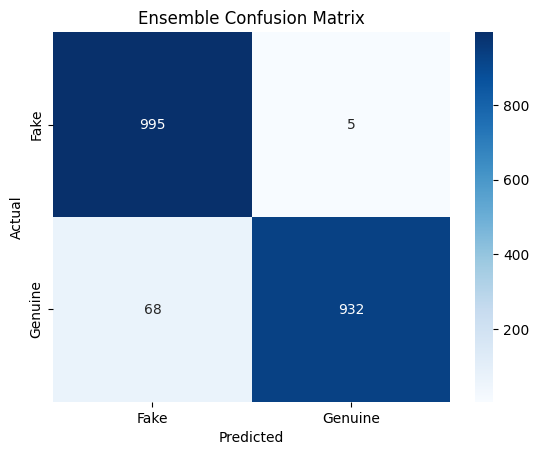

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, labels=["Fake", "Genuine"]):
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Ensemble Confusion Matrix')
    plt.show()

plot_confusion_matrix(val_labels, ensemble_predict_sequential(trained_models, val_texts))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def get_prf_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    return precision, recall, f1

In [ ]:
ensemble_preds = ensemble_predict_sequential(trained_models, val_texts)
precision, recall, f1 = get_prf_metrics(val_labels, ensemble_preds)

🔍 Running predictions for: roberta-base
🔍 Running predictions for: distilbert-base-uncased
🔍 Running predictions for: microsoft/deberta-base


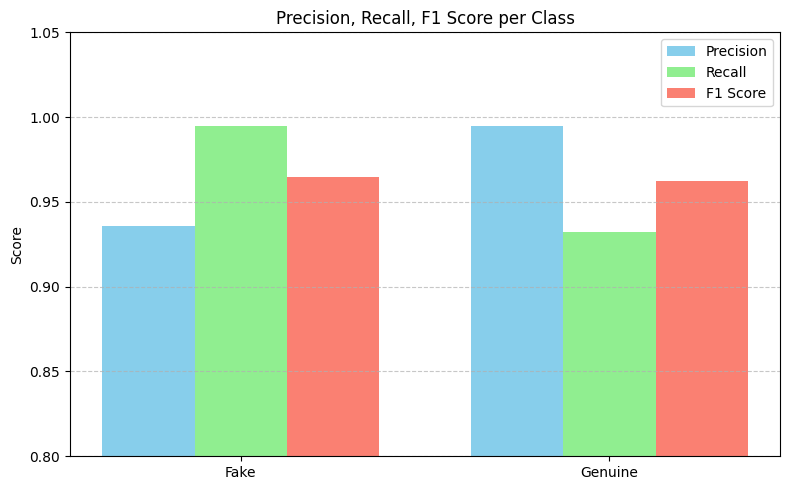

In [ ]:
import numpy as np

labels = ['Fake', 'Genuine']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1 Score', color='salmon')

plt.ylabel('Score')
plt.title('Precision, Recall, F1 Score per Class')
plt.xticks(x, labels)
plt.ylim(0.8, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

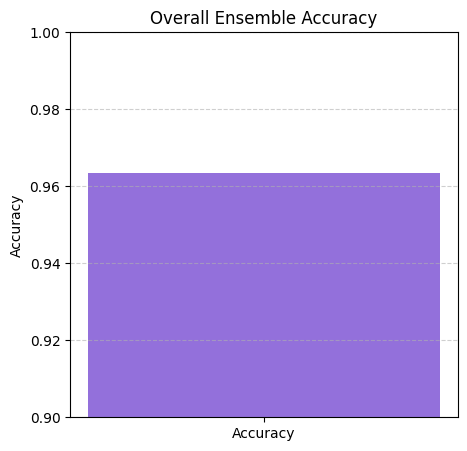

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_labels, ensemble_preds)

plt.figure(figsize=(5, 5))
plt.bar(['Accuracy'], [acc], color='mediumpurple')
plt.ylim(0.9, 1.0)
plt.title('Overall Ensemble Accuracy')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(val_labels, ensemble_preds, target_names=labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report[['precision', 'recall', 'f1-score']] = df_report[['precision', 'recall', 'f1-score']].round(3)
df_report

,precision,recall,f1-score,support
Fake,0.936,0.995,0.965,1000.0000
Genuine,0.995,0.932,0.962,1000.0000
accuracy,0.964,0.964,0.964,0.9635
macro avg,0.965,0.964,0.963,2000.0000
weighted avg,0.965,0.964,0.963,2000.0000


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np
from transformers import AutoTokenizer
from torch.nn.functional import softmax
from tqdm import tqdm

def get_model_probs(model, tokenizer, texts, batch_size=16):
    model.eval()
    model.to('cuda')
    tokenizer.model_max_length = 512
    all_probs = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encodings = tokenizer(batch, truncation=True, padding=True, return_tensors='pt', max_length=512).to('cuda')
            outputs = model(**encodings)
            probs = softmax(outputs.logits, dim=1).cpu().numpy()
            all_probs.append(probs)

    return np.concatenate(all_probs, axis=0)

In [ ]:
from transformers import AutoTokenizer

tokenizers = {
    'roberta-base': AutoTokenizer.from_pretrained('roberta-base'),
    'distilbert-base-uncased': AutoTokenizer.from_pretrained('distilbert-base-uncased'),
    'microsoft/deberta-base': AutoTokenizer.from_pretrained('microsoft/deberta-base'),
    'bert-base-uncased': AutoTokenizer.from_pretrained('bert-base-uncased')
}

In [ ]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

trained_models['roberta-base'][0].to('cpu')
trained_models['distilbert-base-uncased'][0].to('cpu')

probs_deberta = get_model_probs(
    trained_models['microsoft/deberta-base'][0],
    tokenizers['microsoft/deberta-base'],
    val_texts,
    batch_size=8
)

In [ ]:
import numpy as np

final_probs = (
    probs_roberta * 0.33 +
    probs_distilbert * 0.33 +
    probs_deberta * 0.34
)

final_preds = np.argmax(final_probs, axis=1)

✅ Final Ensemble Evaluation (RoBERTa + DistilBERT + DeBERTa):
              precision    recall  f1-score   support

        Fake       0.94      0.99      0.97      1000
     Genuine       0.99      0.94      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.96      2000
weighted avg       0.97      0.96      0.96      2000



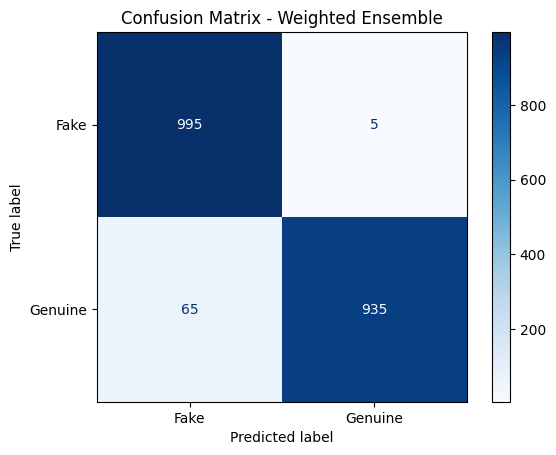

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Final Ensemble Evaluation (RoBERTa + DistilBERT + DeBERTa):")
print(classification_report(val_labels, final_preds, target_names=["Fake", "Genuine"]))

cm = confusion_matrix(val_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Genuine"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Weighted Ensemble")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(val_labels, final_preds)
print(f"\nEnsemble Accuracy: {accuracy:.4f}")


✅ Ensemble Accuracy: 0.9650


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


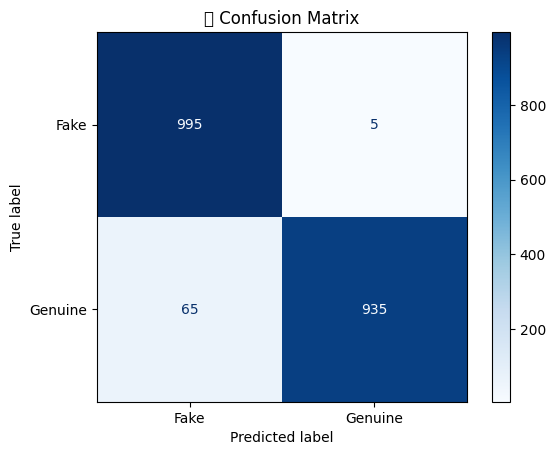

<ipython-input-52-8efc646e899d>:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


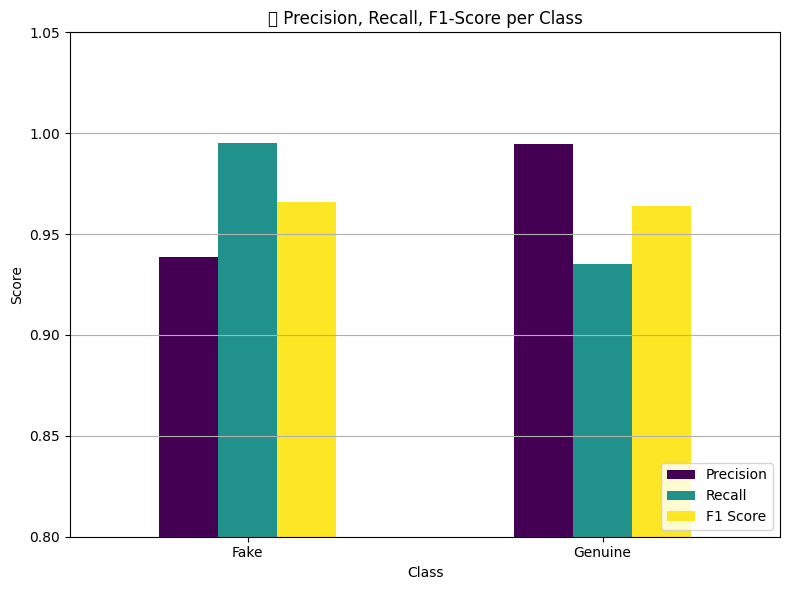

<ipython-input-52-8efc646e899d>:53: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


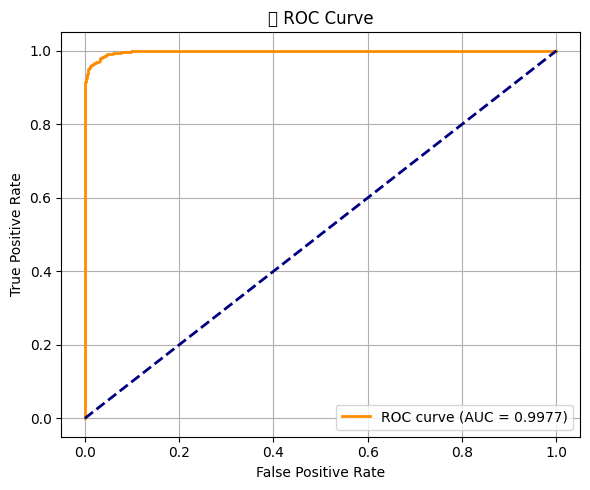

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    roc_curve,
    auc
)
import numpy as np

cm = confusion_matrix(val_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Genuine'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

prec, rec, f1, _ = precision_recall_fscore_support(val_labels, final_preds, average=None, labels=[0, 1])
metrics_df = {
    'Class': ['Fake', 'Genuine'],
    'Precision': prec,
    'Recall': rec,
    'F1 Score': f1
}
metrics_df = pd.DataFrame(metrics_df)
metrics_df.set_index('Class', inplace=True)
metrics_df.plot(kind='bar', figsize=(8, 6), colormap='viridis')
plt.title('Precision, Recall, F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0.8, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

if 'final_probs' in locals():
    fpr, tpr, _ = roc_curve(val_labels, final_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import mode
from sklearn.metrics import classification_report, accuracy_score

preds_roberta = get_model_preds(trained_models['roberta-base'][0], tokenizers['roberta-base'], val_texts)
preds_distilbert = get_model_preds(trained_models['distilbert-base-uncased'][0], tokenizers['distilbert-base-uncased'], val_texts)
preds_deberta = get_model_preds(trained_models['microsoft/deberta-base'][0], tokenizers['microsoft/deberta-base'], val_texts)

all_preds = np.stack([preds_roberta, preds_distilbert, preds_deberta], axis=1)

final_preds_hard = mode(all_preds, axis=1)[0].flatten()

accuracy_hard = accuracy_score(val_labels, final_preds_hard)
print(f"Hard Voting Accuracy: {accuracy_hard:.4f}")
print("\nClassification Report (Hard Voting):\n")
print(classification_report(val_labels, final_preds_hard, target_names=["Fake", "Genuine"]))

✅ Hard Voting Accuracy: 0.9650

🧾 Classification Report (Hard Voting):

              precision    recall  f1-score   support

        Fake       0.94      0.99      0.97      1000
     Genuine       0.99      0.94      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.96      2000
weighted avg       0.97      0.96      0.96      2000



In [ ]:
def get_model_preds(model, tokenizer, texts, batch_size=16):
    model.eval()
    model.to('cuda')
    preds = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encoding = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            input_ids = encoding['input_ids'].to('cuda')
            attention_mask = encoding['attention_mask'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    return np.array(preds)

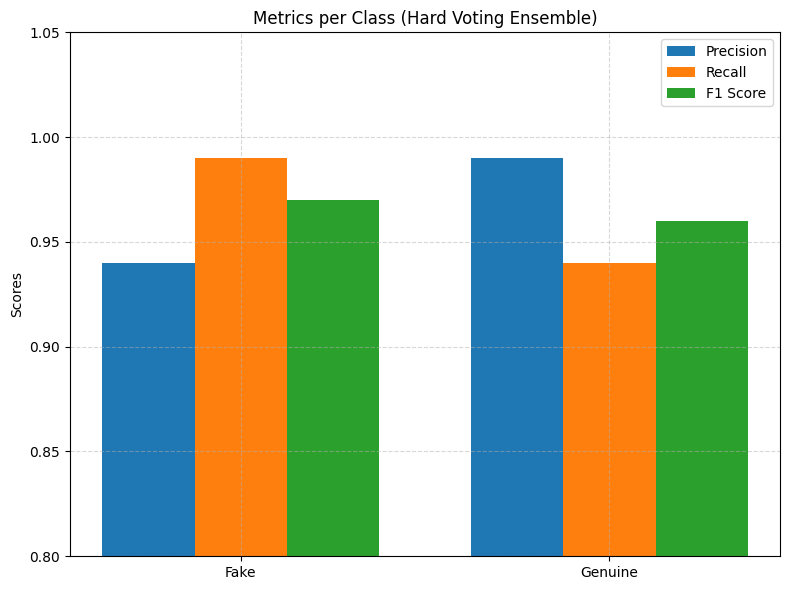

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    'Fake': {'precision': 0.94, 'recall': 0.99, 'f1': 0.97},
    'Genuine': {'precision': 0.99, 'recall': 0.94, 'f1': 0.96}
}

labels = list(metrics.keys())
precision = [metrics[l]['precision'] for l in labels]
recall = [metrics[l]['recall'] for l in labels]
f1 = [metrics[l]['f1'] for l in labels]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Metrics per Class (Hard Voting Ensemble)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0.8, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

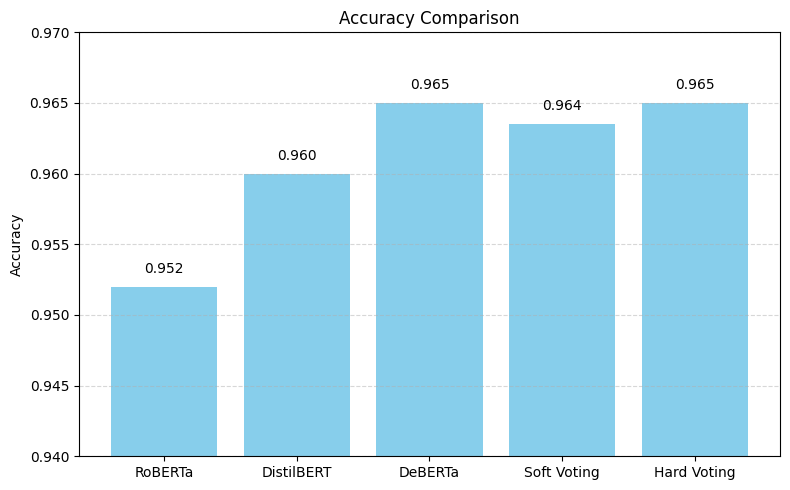

In [ ]:
models = ['RoBERTa', 'DistilBERT', 'DeBERTa', 'Soft Voting', 'Hard Voting']
accuracies = [0.952, 0.960, 0.965, 0.9635, 0.965]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color='skyblue')
plt.ylim(0.94, 0.97)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.001, f'{acc:.3f}', ha='center')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import mode

preds_roberta = get_model_preds(trained_models['roberta-base'][0], tokenizers['roberta-base'], val_texts)
preds_distilbert = get_model_preds(trained_models['distilbert-base-uncased'][0], tokenizers['distilbert-base-uncased'], val_texts)
preds_deberta = get_model_preds(trained_models['microsoft/deberta-base'][0], tokenizers['microsoft/deberta-base'], val_texts)

all_preds = np.stack([preds_roberta, preds_distilbert, preds_deberta])
hard_preds, _ = mode(all_preds, axis=0)
hard_preds = hard_preds.flatten()

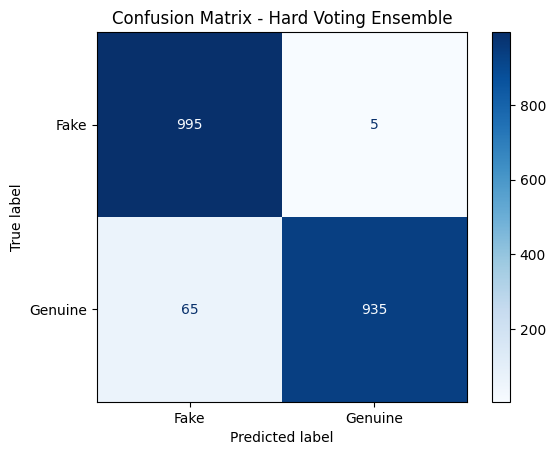

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, hard_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Genuine"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Hard Voting Ensemble")
plt.show()

In [ ]:
probs_roberta = get_model_probs(trained_models['roberta-base'][0], tokenizers['roberta-base'], val_texts)
probs_distilbert = get_model_probs(trained_models['distilbert-base-uncased'][0], tokenizers['distilbert-base-uncased'], val_texts)
probs_deberta = get_model_probs(trained_models['microsoft/deberta-base'][0], tokenizers['microsoft/deberta-base'], val_texts)

In [ ]:
import numpy as np

X_stack = np.hstack([probs_roberta, probs_distilbert, probs_deberta])
y_stack = val_labels

In [ ]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_stack, y_stack)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

stack_preds = meta_model.predict(X_stack)
print("Stacking Ensemble Accuracy:", accuracy_score(y_stack, stack_preds))
print("\nClassification Report (Stacking Ensemble):\n")
print(classification_report(y_stack, stack_preds, target_names=["Fake", "Genuine"]))

📊 Stacking Ensemble Accuracy: 0.972

🧾 Classification Report (Stacking Ensemble):

              precision    recall  f1-score   support

        Fake       0.96      0.99      0.97      1000
     Genuine       0.99      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



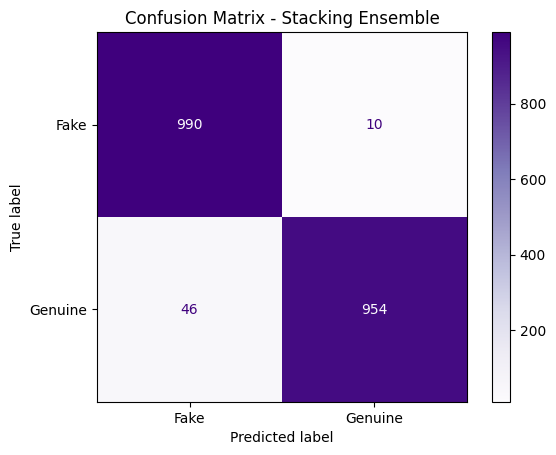

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_stack, stack_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Genuine"])
disp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix - Stacking Ensemble")
plt.show()

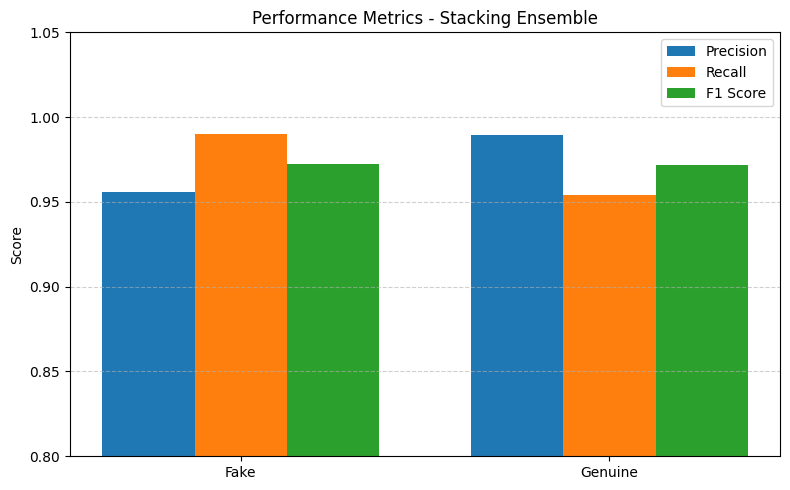

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

precision, recall, f1, _ = precision_recall_fscore_support(y_stack, stack_preds, average=None)

labels = ["Fake", "Genuine"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.ylabel('Score')
plt.title('Performance Metrics - Stacking Ensemble')
plt.xticks(x, labels)
plt.ylim(0.8, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

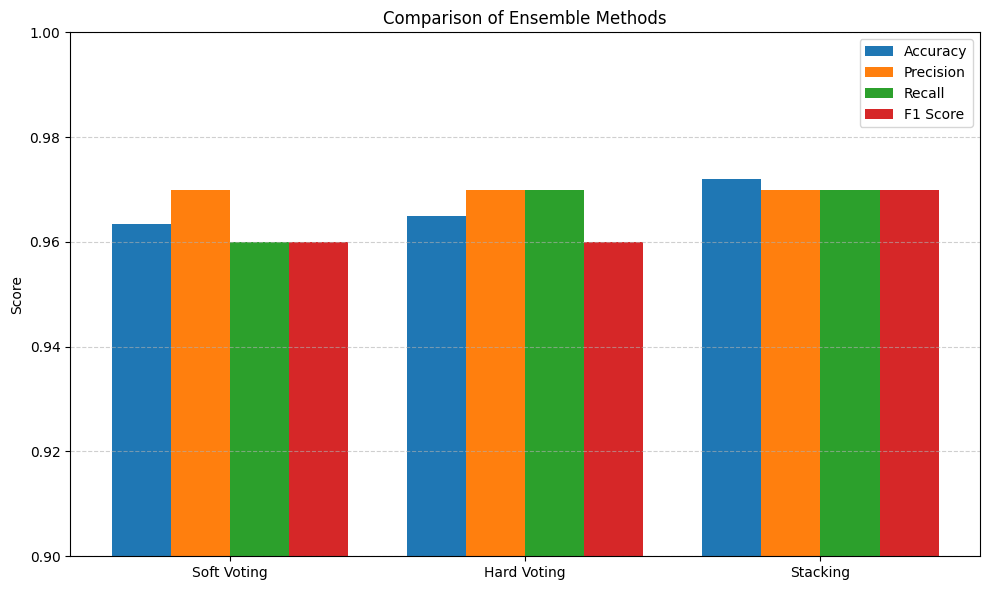

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['Soft Voting', 'Hard Voting', 'Stacking']
accuracy = [0.9635, 0.9650, 0.9720]
precision = [0.97, 0.97, 0.97]
recall = [0.96, 0.97, 0.97]
f1 = [0.96, 0.96, 0.97]

x = np.arange(len(methods))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5 * width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5 * width, precision, width, label='Precision')
plt.bar(x + 0.5 * width, recall, width, label='Recall')
plt.bar(x + 1.5 * width, f1, width, label='F1 Score')

plt.ylabel('Score')
plt.title('Comparison of Ensemble Methods')
plt.xticks(x, methods)
plt.ylim(0.9, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()